## 规则基准策略回测结果分析（rule_based）

本 Notebook 解析 `回测/res/dynamic_weights.json`（由天软回测 XML 转换而来），构建结构化的 `DataFrame`，计算尽可能全面的绩效与风险指标，并进行可视化与解释。

分析内容包括：
- A. 环境与数据读取
- B. 数据清洗与对齐
- C. 核心收益曲线可视化
- D. 指标计算（收益 / 风险 / 相对基准）
- E. 风险分析与归因
- F. 与框架自带统计结果交叉验证
- G. 结论与后续扩展方向

### A. 环境与数据读取

In [16]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from sklearn.linear_model import LinearRegression

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.grid'] = True
# 中文字体与负号支持
plt.rcParams['font.sans-serif'] = ['PingFang SC', 'Songti SC', 'Microsoft YaHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

DATA_PATH = Path('回测/res/rule_based.json')
assert DATA_PATH.exists(), '找不到数据文件: %s' % DATA_PATH

with DATA_PATH.open('r', encoding='utf-8') as f:
    ts_data = json.load(f)

list(ts_data.keys())

['每期收益率',
 '累计收益率',
 '月度绝对收益(原始)',
 '月度超额收益(原始)',
 '多空月度收益(原始)',
 '收益率检验',
 '换手率',
 '因子显著性统计',
 '因子区分度检验',
 '因子延续性检验',
 '因子稳定性检验',
 '每期因子权重',
 '回测状态']

In [17]:
# 查看各个 section 的示例结构
for key, value in ts_data.items():
    if isinstance(value, list) and value:
        print('=== %s ===' % key)
        df_preview = pd.DataFrame(value)
        display(df_preview.head(3))
    else:
        print('=== %s === (非列表或为空) -> 跳过预览' % key)
    print()

=== 每期收益率 ===


,开始日,截止日,交易点数,基准,第1组,第2组,第3组,第4组,第5组
0,2024-02-01,2024-02-29,1,1.15,-0.10,-0.10,-0.10,-0.10,-0.10
1,2024-03-01,2024-03-29,21,0.07,-0.99,1.09,3.57,-1.94,-3.48
2,2024-04-01,2024-04-30,20,2.04,2.58,4.09,1.76,-1.92,2.85



=== 累计收益率 ===


,开始日,截止日,交易点数,基准,第1组,第2组,第3组,第4组,第5组
0,2024-02-01,2024-02-29,1,1.15,-0.10,-0.10,-0.10,-0.10,-0.10
1,2024-03-01,2024-03-29,21,1.23,-1.09,0.98,3.47,-2.04,-3.57
2,2024-04-01,2024-04-30,20,3.30,1.47,5.11,5.29,-3.92,-0.83



=== 月度绝对收益(原始) ===


,开始日,开始日_str,截止日,截止日_str,交易点数,基准,第1组,第2组,第3组,第4组,第5组
0,45323.0,2024-01-31,45351.0,2024-02-28,1,1.15,-0.10,-0.10,-0.10,-0.10,-0.10
1,45352.0,2024-02-29,45380.0,2024-03-28,21,0.07,-0.99,1.09,3.57,-1.94,-3.48
2,45383.0,2024-03-31,45412.0,2024-04-29,20,2.04,2.58,4.09,1.76,-1.92,2.85



=== 月度超额收益(原始) ===


,开始日,开始日_str,截止日,截止日_str,交易点数,基准,第1组,第2组,第3组,第4组,第5组
0,45323.0,2024-01-31,45351.0,2024-02-28,1,1.15,-1.25,-1.25,-1.25,-1.25,-1.25
1,45352.0,2024-02-29,45380.0,2024-03-28,21,0.07,-1.06,1.01,3.50,-2.02,-3.55
2,45383.0,2024-03-31,45412.0,2024-04-29,20,2.04,0.54,2.05,-0.28,-3.96,0.80



=== 多空月度收益(原始) ===


,开始日,开始日_str,截止日,截止日_str,交易点数,第一组vs最后一组,第一组vs最后一组->累计
0,45323.0,2024-01-31,45351.0,2024-02-28,1,0.00,0.00
1,45352.0,2024-02-29,45380.0,2024-03-28,21,2.49,2.49
2,45383.0,2024-03-31,45412.0,2024-04-29,20,-0.26,2.30



=== 收益率检验 ===


,组名,整体@平均收益(%),整体@标准差(%),整体@夏普比率,整体@胜率(%),整体@最大回撤%(日线),近1年@平均收益(%),近1年@标准差(%),近1年@夏普比率,近1年@胜率(%),...,近2年@平均收益(%),近2年@标准差(%),近2年@夏普比率,近2年@胜率(%),近2年@最大回撤%(日线),近3年@平均收益(%),近3年@标准差(%),近3年@夏普比率,近3年@胜率(%),近3年@最大回撤%(日线)
0,第1组,1.93,5.27,0.37,55.56,-10.44,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,第2组,1.01,5.75,0.18,44.44,-10.85,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,第3组,1.59,7.55,0.21,44.44,-11.60,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None



=== 换手率 ===


,开始日,截止日,基准,第1组,第2组,第3组,第4组,第5组
0,2024-03-29,2024-02-29,0.0,50.0,90.0,80.0,70.0,50.0
1,2024-04-30,2024-03-29,0.0,50.0,80.0,90.0,70.0,50.0
2,2024-05-31,2024-04-30,0.0,20.0,30.0,30.0,30.0,10.0



=== 因子显著性统计 ===


,组名,整体@超额均值(%),整体@跟踪误差(%),整体@信息比率,整体@超额概率(%),整体@T-Stat,整体@P-Value,近1年@超额均值(%),近1年@跟踪误差(%),近1年@信息比率,...,近2年@信息比率,近2年@超额概率(%),近2年@T-Stat,近2年@P-Value,近3年@超额均值(%),近3年@跟踪误差(%),近3年@信息比率,近3年@超额概率(%),近3年@T-Stat,近3年@P-Value
0,第1组,0.81,2.65,0.31,66.67,0.92,80.71,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,第2组,-0.10,1.94,-0.05,66.67,-0.16,43.94,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,第3组,0.47,2.47,0.19,55.56,0.58,70.98,None,None,None,...,None,None,None,None,None,None,None,None,None,None



=== 因子区分度检验 ===


,项目,整体@平均收益(%),整体@标准差(%),整体@夏普比率,整体@胜率(%),整体@T-Stat,整体@P-Value,近1年@平均收益(%),近1年@标准差(%),近1年@夏普比率,...,近2年@夏普比率,近2年@胜率(%),近2年@T-Stat,近2年@P-Value,近3年@平均收益(%),近3年@标准差(%),近3年@夏普比率,近3年@胜率(%),近3年@T-Stat,近3年@P-Value
0,第一组vs最后一组,-0.44,7.33,-0.06,44.44,-0.18,43.13,None,None,None,...,None,None,None,None,None,None,None,None,None,None



=== 因子延续性检验 ===


,因子截止日,检验开始日,检验截止日,IC,P-value
0,2024-02-29,2024-03-01,2024-03-29,0.13,0.36
1,2024-03-29,2024-03-30,2024-04-30,0.11,0.46
2,2024-04-30,2024-05-01,2024-05-31,0.25,0.08



=== 因子稳定性检验 ===


,开始日,上期截止日,间隔期数,自相关系数,买入衰减(%),买入反转(%),卖出衰减(%),卖出反转(%)
0,2024-03-29,2024-02-29,1,0.61,50.0,0.0,50.0,0.0
1,2024-04-30,2024-03-29,1,0.64,50.0,0.0,50.0,0.0
2,2024-05-31,2024-04-30,1,0.97,80.0,0.0,90.0,0.0



=== 每期因子权重 ===


,month,regime,MOM20_w,MOM120_w,RSI_w,PB_w,PE_w,DIV_w,ROE_w,PROFIT_GR_w,VOL_w,BETA_w
0,2024-02-01,Regime_Bull,25,25,10,5,5,5,7.5,7.5,5,5
1,2024-03-01,Regime_Bear,4,4,2,15,15,10,10.0,10.0,20,10
2,2024-04-01,Regime_Bull,25,25,10,5,5,5,7.5,7.5,5,5



=== 回测状态 === (非列表或为空) -> 跳过预览



### 辅助函数：日期解析、数值处理与 section 归一化

In [18]:
from datetime import datetime, timedelta


def excel_serial_to_datetime(serial):
    """将 Excel / 天软常见的序列日转换为 pandas Timestamp。

    采用 1899-12-30 为基准（serial=1 -> 1900-01-01）。
    """
    try:
        serial = float(serial)
    except (TypeError, ValueError):
        return None
    base_date = datetime(1899, 12, 30)
    return pd.Timestamp(base_date + timedelta(days=int(serial)))


def parse_date_series(s):
    """智能解析日期列：既支持字符串日期，也支持 Excel 序列日。"""
    if s.dropna().empty:
        return pd.to_datetime(s, errors='coerce')

    if np.issubdtype(s.dtype, np.datetime64):
        return s

    if s.dtype == 'object':
        parsed = pd.to_datetime(s, errors='coerce')
        if parsed.notna().mean() > 0.8:
            return parsed
        try:
            as_num = pd.to_numeric(s, errors='coerce')
            return as_num.apply(excel_serial_to_datetime)
        except Exception:
            return parsed

    if np.issubdtype(s.dtype, np.number):
        return s.apply(excel_serial_to_datetime)

    return pd.to_datetime(s, errors='coerce')


def to_float_df(df):
    """将所有可转为数值的列转为 float，其余保留原类型；'-' 等缺失转 NaN。"""
    df = df.copy()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].replace('-', np.nan)
        try:
            num = pd.to_numeric(df[col], errors='coerce')
            if num.notna().mean() > 0.5:
                df[col] = num.astype(float)
        except Exception:
            pass
    return df


def normalize_section_to_df(key, value):
    """将顶层某个 section（通常是 list[dict]）归一化为 DataFrame。"""
    if not isinstance(value, list) or len(value) == 0:
        print('[WARN] section `%s` 不是非空列表，跳过解析' % key)
        return None
    df = pd.DataFrame(value)
    df = to_float_df(df)
    for col in list(df.columns):
        col_str = str(col)
        if ('开始日' in col_str) or ('起始日' in col_str):
            df['start_date'] = parse_date_series(df[col])
        if ('截止日' in col_str) or ('终止日' in col_str) or ('结束日' in col_str):
            df['end_date'] = parse_date_series(df[col])
    if 'end_date' in df.columns:
        df['date'] = df['end_date']
    elif 'start_date' in df.columns:
        df['date'] = df['start_date']
    return df


def rename_group_cols(df):
    """统一分组列命名：benchmark, g1..g5, ls。"""
    df = df.copy()
    mapping = {}
    for col in df.columns:
        col_str = str(col)
        if '基准' in col_str:
            mapping[col] = 'benchmark'
        elif ('第1组' in col_str) or ('1组' in col_str):
            mapping[col] = 'g1'
        elif ('第2组' in col_str) or ('2组' in col_str):
            mapping[col] = 'g2'
        elif ('第3组' in col_str) or ('3组' in col_str):
            mapping[col] = 'g3'
        elif ('第4组' in col_str) or ('4组' in col_str):
            mapping[col] = 'g4'
        elif ('第5组' in col_str) or ('5组' in col_str):
            mapping[col] = 'g5'
        elif '第一组vs最后一组' in col_str or '一组vs' in col_str:
            mapping[col] = 'ls'
    return df.rename(columns=mapping)


sections = {}
for key, value in ts_data.items():
    df_sec = normalize_section_to_df(key, value)
    if df_sec is not None:
        sections[key] = rename_group_cols(df_sec)

print('可用 section:', list(sections.keys()))

# 看看“每期收益率”示例
if '每期收益率' in sections:
    display(sections['每期收益率'].head())
else:
    # 回退到任意一个 section
    first_key = list(sections.keys())[0]
    display(sections[first_key].head())

[WARN] section `回测状态` 不是非空列表，跳过解析
可用 section: ['每期收益率', '累计收益率', '月度绝对收益(原始)', '月度超额收益(原始)', '多空月度收益(原始)', '收益率检验', '换手率', '因子显著性统计', '因子区分度检验', '因子延续性检验', '因子稳定性检验', '每期因子权重']


,开始日,截止日,交易点数,benchmark,g1,g2,g3,g4,g5,start_date,end_date,date
0,2024-02-01,2024-02-29,1.0,1.15,-0.10,-0.10,-0.10,-0.10,-0.10,2024-02-01,2024-02-29,2024-02-29
1,2024-03-01,2024-03-29,21.0,0.07,-0.99,1.09,3.57,-1.94,-3.48,2024-03-01,2024-03-29,2024-03-29
2,2024-04-01,2024-04-30,20.0,2.04,2.58,4.09,1.76,-1.92,2.85,2024-04-01,2024-04-30,2024-04-30
3,2024-05-01,2024-05-31,20.0,-0.08,3.78,0.82,-0.09,0.22,-2.35,2024-05-01,2024-05-31,2024-05-31
4,2024-06-01,2024-06-28,19.0,-2.73,1.89,-1.17,-0.83,-5.35,-6.37,2024-06-01,2024-06-28,2024-06-28


### B. 数据清洗与对齐（以“每期收益率”为主时间轴）

In [19]:
# 1) 选择 "每期收益率" 作为主时间轴
main_key = None
for k in ['每期收益率', '月度收益率', 'PeriodReturn']:
    if k in sections:
        main_key = k
        break
if main_key is None:
    raise ValueError('找不到合适的主时间轴 section（例如 每期收益率）')

main_df = sections[main_key].copy()
if 'date' not in main_df.columns:
    raise ValueError('主时间轴 DataFrame 中缺少 date 列，无法对齐')

main_df = main_df.sort_values('date').reset_index(drop=True)
main_df.set_index('date', inplace=True)

# 2) 其余 section 外连接到主时间轴
aligned = main_df.copy()
for key, df_sec in sections.items():
    if key == main_key:
        continue
    if 'date' not in df_sec.columns:
        print('[INFO] section `%s` 无 date 列，跳过对齐' % key)
        continue
    tmp = df_sec.set_index('date').sort_index()
    # 丢弃各 section 自己的 start_date / end_date，避免重复列名冲突
    tmp = tmp.drop(columns=['start_date', 'end_date'], errors='ignore')
    new_cols = {}
    for c in tmp.columns:
        new_cols[c] = '%s__%s' % (key, c)
    tmp = tmp.rename(columns=new_cols)
    aligned = aligned.join(tmp, how='outer')

aligned.head()

[INFO] section `收益率检验` 无 date 列，跳过对齐
[INFO] section `因子显著性统计` 无 date 列，跳过对齐
[INFO] section `因子区分度检验` 无 date 列，跳过对齐
[INFO] section `每期因子权重` 无 date 列，跳过对齐


,开始日,截止日,交易点数,benchmark,g1,g2,g3,g4,g5,start_date,...,因子延续性检验__IC,因子延续性检验__P-value,因子稳定性检验__开始日,因子稳定性检验__上期截止日,因子稳定性检验__间隔期数,因子稳定性检验__自相关系数,因子稳定性检验__买入衰减(%),因子稳定性检验__买入反转(%),因子稳定性检验__卖出衰减(%),因子稳定性检验__卖出反转(%)
date,,,,,,,,,,,,,,,,,,,,,
2024-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-29,2024-02-01,2024-02-29,1.0,1.15,-0.10,-0.10,-0.10,-0.10,-0.10,2024-02-01,...,NaN,NaN,2024-03-29,2024-02-29,1.0,0.61,50.0,0.0,50.0,0.0
2024-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-29,2024-03-01,2024-03-29,21.0,0.07,-0.99,1.09,3.57,-1.94,-3.48,2024-03-01,...,0.13,0.36,2024-04-30,2024-03-29,1.0,0.64,50.0,0.0,50.0,0.0
2024-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 收益率单位说明与标准化

In [20]:
# 从 "月度绝对收益(原始)" 中提取主要月度收益序列
abs_key = None
for k in ['月度绝对收益(原始)', '月度绝对收益', 'AbsoluteMonthlyReturn']:
    if k in sections:
        abs_key = k
        break

if abs_key is None:
    print('[WARN] 找不到 月度绝对收益(原始) section，将尝试从主表中推断收益列')
    monthly_ret_df = main_df.copy()
else:
    monthly_ret_df = sections[abs_key].copy().set_index('date').sort_index()

monthly_ret_df = rename_group_cols(monthly_ret_df)

# 为 benchmark/g1..g5 创建百分比版和小数版
returns_cols = [c for c in ['benchmark', 'g1', 'g2', 'g3', 'g4', 'g5'] if c in monthly_ret_df.columns]
for col in returns_cols:
    monthly_ret_df[col + '_pct'] = monthly_ret_df[col]
    monthly_ret_df[col] = monthly_ret_df[col + '_pct'] / 100.0

# 若存在多空表，则提取 ls 列
ls_key = None
for k in ['多空月度收益(原始)', '多空月度收益', 'LongShortMonthlyReturn']:
    if k in sections:
        ls_key = k
        break

if ls_key is not None:
    ls_df = rename_group_cols(sections[ls_key]).set_index('date').sort_index()
    if 'ls' in ls_df.columns:
        # 可能存在多个名为 ls 的列（列名重复时 pandas 返回 DataFrame），只取第一列
        ls_col = ls_df['ls']
        if isinstance(ls_col, pd.DataFrame):
            ls_col = ls_col.iloc[:, 0]
        monthly_ret_df['ls_pct'] = ls_col
        monthly_ret_df['ls'] = ls_col / 100.0
else:
    if ('g1' in monthly_ret_df.columns) and ('g5' in monthly_ret_df.columns):
        monthly_ret_df['ls'] = monthly_ret_df['g1'] - monthly_ret_df['g5']
        monthly_ret_df['ls_pct'] = monthly_ret_df['ls'] * 100.0

monthly_ret_df[[c for c in ['benchmark', 'g5'] if c in monthly_ret_df.columns]].head()

,benchmark,g5
date,,
2024-02-28,0.0115,-0.0010
2024-03-28,0.0007,-0.0348
2024-04-29,0.0204,0.0285
2024-05-30,-0.0008,-0.0235
2024-06-27,-0.0273,-0.0637


### C. 核心收益曲线可视化（累计收益 / 超额 / 多空）

In [21]:
def build_nav_from_return(r):
    r = r.dropna()
    return (1.0 + r).cumprod()

nav = pd.DataFrame(index=monthly_ret_df.index.sort_values())
if 'benchmark' in monthly_ret_df.columns:
    nav['benchmark'] = build_nav_from_return(monthly_ret_df['benchmark'])
if 'g5' in monthly_ret_df.columns:
    nav['g5'] = build_nav_from_return(monthly_ret_df['g5'])
if 'g1' in monthly_ret_df.columns:
    nav['g1'] = build_nav_from_return(monthly_ret_df['g1'])
if 'ls' in monthly_ret_df.columns:
    nav['ls'] = build_nav_from_return(monthly_ret_df['ls'])

nav.head()

,benchmark,g5,g1,ls
date,,,,
2024-02-28,1.011500,0.999000,0.999000,1.000000
2024-03-28,1.012208,0.964235,0.989110,1.024900
2024-04-29,1.032857,0.991715,1.014629,1.022235
2024-05-30,1.032031,0.968410,1.052982,1.084898
2024-06-27,1.003856,0.906722,1.072883,1.174511


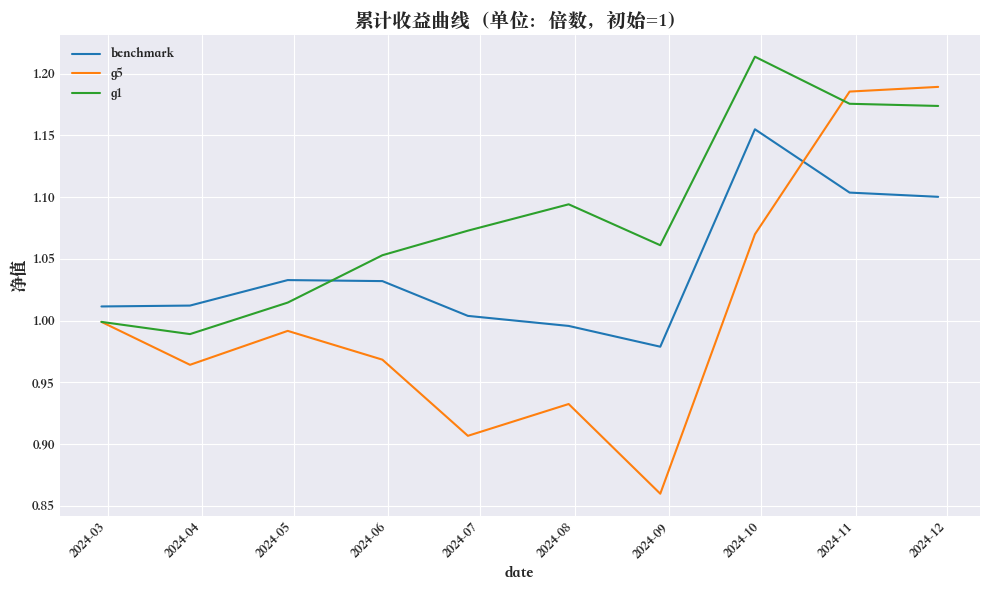

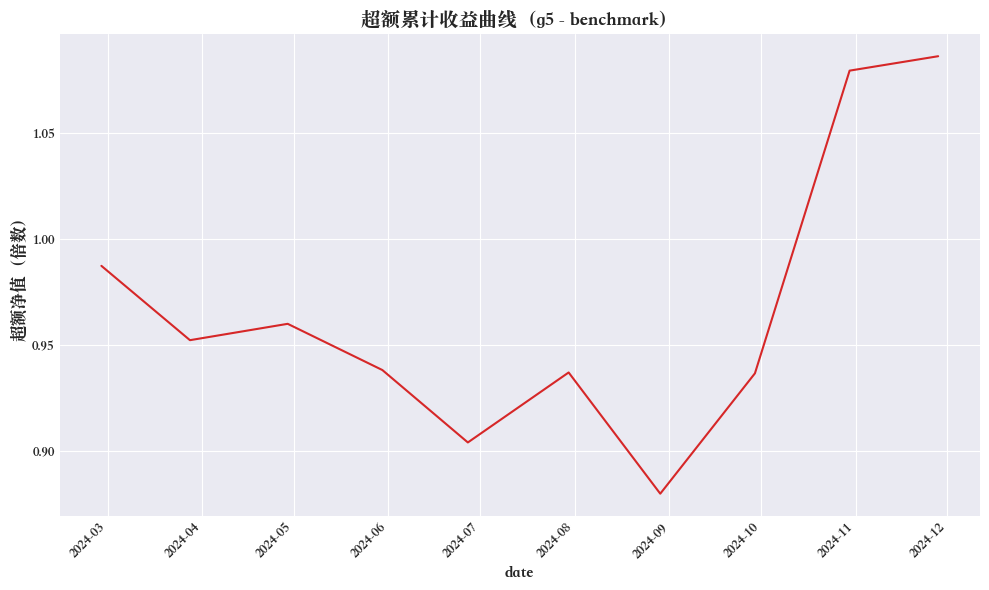

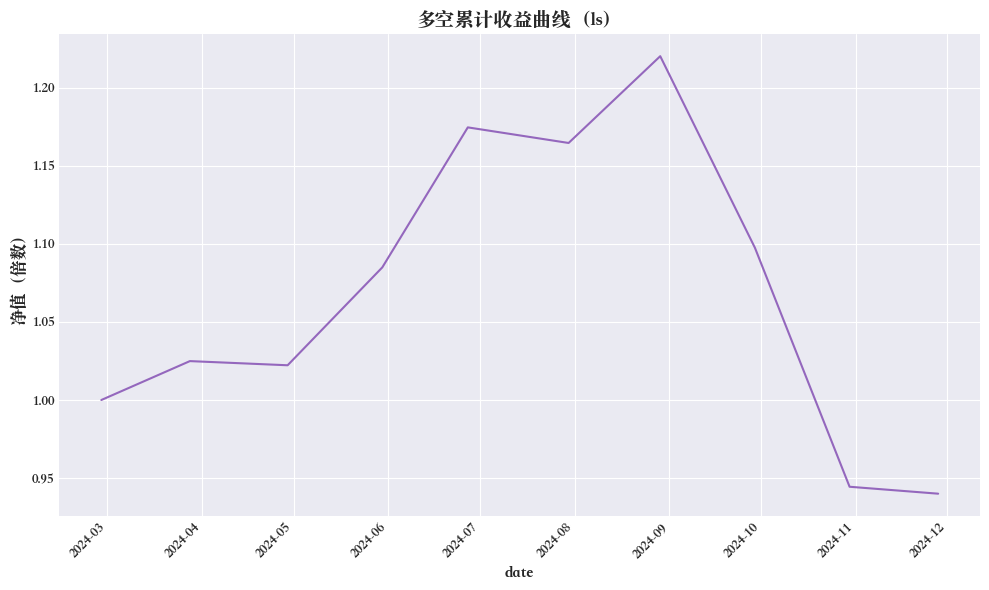

In [22]:
# 1) 累计收益曲线：benchmark vs g5 (可选 g1)
fig, ax = plt.subplots()
cols_to_plot = [c for c in ['benchmark', 'g5', 'g1'] if c in nav.columns]
nav[cols_to_plot].plot(ax=ax)
ax.set_title('累计收益曲线（单位：倍数，初始=1）')
ax.set_ylabel('净值')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 2) 超额累计收益曲线：g5 - benchmark
if ('benchmark' in monthly_ret_df.columns) and ('g5' in monthly_ret_df.columns):
    excess = monthly_ret_df['g5'] - monthly_ret_df['benchmark']
    nav_excess = build_nav_from_return(excess)
    fig, ax = plt.subplots()
    nav_excess.plot(ax=ax, color='C3')
    ax.set_title('超额累计收益曲线（g5 - benchmark）')
    ax.set_ylabel('超额净值（倍数）')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 3) 多空累计曲线：ls
if 'ls' in nav.columns:
    fig, ax = plt.subplots()
    nav['ls'].plot(ax=ax, color='C4')
    ax.set_title('多空累计收益曲线（ls）')
    ax.set_ylabel('净值（倍数）')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### D. 指标计算（收益 / 风险 / 相对基准）

In [23]:
PER_YEAR = 12  # 月度数据


def cagr(returns, periods_per_year=PER_YEAR):
    r = returns.dropna()
    if r.empty:
        return np.nan
    total_return = (1.0 + r).prod() - 1.0
    years = float(len(r)) / float(periods_per_year)
    if years <= 0:
        return np.nan
    return (1.0 + total_return) ** (1.0 / years) - 1.0


def annualized_vol(returns, periods_per_year=PER_YEAR):
    r = returns.dropna()
    if r.empty:
        return np.nan
    return r.std(ddof=1) * np.sqrt(periods_per_year)


def sharpe_ratio(returns, rf=0.0, periods_per_year=PER_YEAR):
    r = returns.dropna()
    if r.empty:
        return np.nan
    excess = r - rf / float(periods_per_year)
    vol = excess.std(ddof=1)
    if vol == 0:
        return np.nan
    return (excess.mean() * periods_per_year) / (vol * np.sqrt(periods_per_year))


def sortino_ratio(returns, rf=0.0, periods_per_year=PER_YEAR):
    r = returns.dropna()
    if r.empty:
        return np.nan
    excess = r - rf / float(periods_per_year)
    downside = excess[excess < 0]
    if downside.empty:
        return np.nan
    downside_vol = downside.std(ddof=1) * np.sqrt(periods_per_year)
    if downside_vol == 0:
        return np.nan
    return cagr(returns, periods_per_year) / downside_vol


def max_drawdown(returns):
    r = returns.dropna()
    if r.empty:
        return np.nan
    wealth = (1.0 + r).cumprod()
    peak = wealth.cummax()
    dd = wealth / peak - 1.0
    return dd.min()


def drawdown_series(returns):
    r = returns.dropna()
    wealth = (1.0 + r).cumprod()
    peak = wealth.cummax()
    return wealth / peak - 1.0


def calmar_ratio(returns):
    mdd = max_drawdown(returns)
    if (mdd >= 0) or np.isnan(mdd):
        return np.nan
    return cagr(returns) / abs(mdd)


def win_rate(returns):
    r = returns.dropna()
    if r.empty:
        return np.nan
    return (r > 0).mean()


def max_monthly_stats(returns):
    r = returns.dropna()
    if r.empty:
        return np.nan, np.nan
    return r.min(), r.max()


def skew_kurtosis(returns):
    r = returns.dropna()
    if len(r) < 3:
        return np.nan, np.nan
    return stats.skew(r), stats.kurtosis(r, fisher=True)


def var_cvar(returns, alpha=0.95):
    r = returns.dropna()
    if r.empty:
        return np.nan, np.nan
    losses = -r
    var = np.quantile(losses, alpha)
    cvar = losses[losses >= var].mean()
    return var, cvar


def tracking_error_and_ir(strategy, benchmark):
    aligned = pd.concat([strategy, benchmark], axis=1, join='inner').dropna()
    if aligned.shape[0] == 0:
        return np.nan, np.nan
    excess = aligned.iloc[:, 0] - aligned.iloc[:, 1]
    te = annualized_vol(excess)
    if np.isnan(te) or te == 0:
        return te, np.nan
    ir = cagr(excess) / te
    return te, ir


def alpha_beta(strategy, benchmark):
    aligned = pd.concat([strategy, benchmark], axis=1, join='inner').dropna()
    if aligned.shape[0] < 3:
        return {
            'alpha': np.nan,
            'beta': np.nan,
            'alpha_t': np.nan,
            'beta_t': np.nan,
            'r2': np.nan,
        }
    y = aligned.iloc[:, 0].values.reshape(-1, 1)
    x = aligned.iloc[:, 1].values.reshape(-1, 1)
    reg = LinearRegression().fit(x, y)
    beta = float(reg.coef_[0, 0])
    alpha = float(reg.intercept_[0])
    y_pred = reg.predict(x).ravel()
    resid = aligned.iloc[:, 0].values - y_pred
    ss_res = np.sum(resid ** 2)
    ss_tot = np.sum((aligned.iloc[:, 0].values - aligned.iloc[:, 0].mean()) ** 2)
    if ss_tot != 0:
        r2 = 1.0 - ss_res / ss_tot
    else:
        r2 = np.nan

    n = len(aligned)
    if n > 2:
        se2 = ss_res / float(n - 2)
        sx2 = np.sum((x - x.mean()) ** 2)
        if sx2 != 0:
            se_beta = np.sqrt(se2 / sx2)
            beta_t = beta / se_beta if se_beta != 0 else np.nan
        else:
            beta_t = np.nan
        if sx2 != 0:
            se_alpha = np.sqrt(se2 * (1.0 / n + x.mean() ** 2 / sx2))
        else:
            se_alpha = np.nan
        if (se_alpha is not None) and (se_alpha != 0) and (not np.isnan(se_alpha)):
            alpha_t = alpha / se_alpha
        else:
            alpha_t = np.nan
    else:
        alpha_t = np.nan
        beta_t = np.nan

    return {
        'alpha': alpha * PER_YEAR,  # 年化 alpha 近似
        'beta': beta,
        'alpha_t': alpha_t,
        'beta_t': beta_t,
        'r2': r2,
    }

In [24]:
# 构建需要评估的序列：benchmark, g5, excess, ls
series_dict = {}
if 'benchmark' in monthly_ret_df.columns:
    series_dict['benchmark'] = monthly_ret_df['benchmark']
if 'g5' in monthly_ret_df.columns:
    series_dict['g5'] = monthly_ret_df['g5']
if ('benchmark' in monthly_ret_df.columns) and ('g5' in monthly_ret_df.columns):
    series_dict['excess_g5_vs_bm'] = monthly_ret_df['g5'] - monthly_ret_df['benchmark']
if 'ls' in monthly_ret_df.columns:
    series_dict['ls'] = monthly_ret_df['ls']

metrics = []
for name, r in series_dict.items():
    c = cagr(r)
    v = annualized_vol(r)
    s = sharpe_ratio(r)
    so = sortino_ratio(r)
    mdd = max_drawdown(r)
    cal = calmar_ratio(r)
    wr = win_rate(r)
    mn, mx = max_monthly_stats(r)
    sk, ku = skew_kurtosis(r)
    var95, cvar95 = var_cvar(r, 0.95)
    te, ir = (np.nan, np.nan)
    ab = {'alpha': np.nan, 'beta': np.nan, 'alpha_t': np.nan, 'beta_t': np.nan, 'r2': np.nan}
    if (name != 'benchmark') and ('benchmark' in series_dict):
        te, ir = tracking_error_and_ir(r, series_dict['benchmark'])
        ab = alpha_beta(r, series_dict['benchmark'])
    metrics.append({
        'series': name,
        'CAGR': c,
        'AnnVol': v,
        'Sharpe': s,
        'Sortino': so,
        'MaxDD': mdd,
        'Calmar': cal,
        'WinRate': wr,
        'MinMonth': mn,
        'MaxMonth': mx,
        'Skew': sk,
        'Kurtosis': ku,
        'VaR95': var95,
        'CVaR95': cvar95,
        'TrackingError': te,
        'InfoRatio': ir,
        'Alpha': ab['alpha'],
        'Beta': ab['beta'],
        'Alpha_t': ab['alpha_t'],
        'Beta_t': ab['beta_t'],
        'R2': ab['r2'],
    })

metrics_df = pd.DataFrame(metrics).set_index('series')
metrics_df

,CAGR,AnnVol,Sharpe,Sortino,MaxDD,Calmar,WinRate,MinMonth,MaxMonth,Skew,Kurtosis,VaR95,CVaR95,TrackingError,InfoRatio,Alpha,Beta,Alpha_t,Beta_t,R2
series,,,,,,,,,,,,,,,,,,,,
benchmark,0.121533,0.215217,0.623927,2.103121,-0.052243,2.326298,0.4,-0.0444,0.1799,2.216772,3.817539,0.036705,0.0444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
g5,0.231295,0.327490,0.775352,2.161099,-0.139306,1.660342,0.5,-0.0779,0.2444,1.374643,1.177314,0.071510,0.0779,0.215429,0.485184,0.098591,1.156758,0.391802,3.309420,0.577887
excess_g5_vs_bm,0.104523,0.215429,0.555357,1.657073,-0.108820,0.960512,0.5,-0.0610,0.1524,1.204136,0.768173,0.049930,0.0610,0.279655,-0.167200,0.098591,0.156758,0.391802,0.448475,0.024525
ls,-0.071521,0.239321,-0.196556,-0.320909,-0.229529,-0.311602,0.4,-0.1394,0.0826,-0.817320,-0.258694,0.121895,0.1394,0.377224,-0.602071,0.009064,-0.417811,0.034555,-1.146751,0.141174


### E. 风险分析与归因

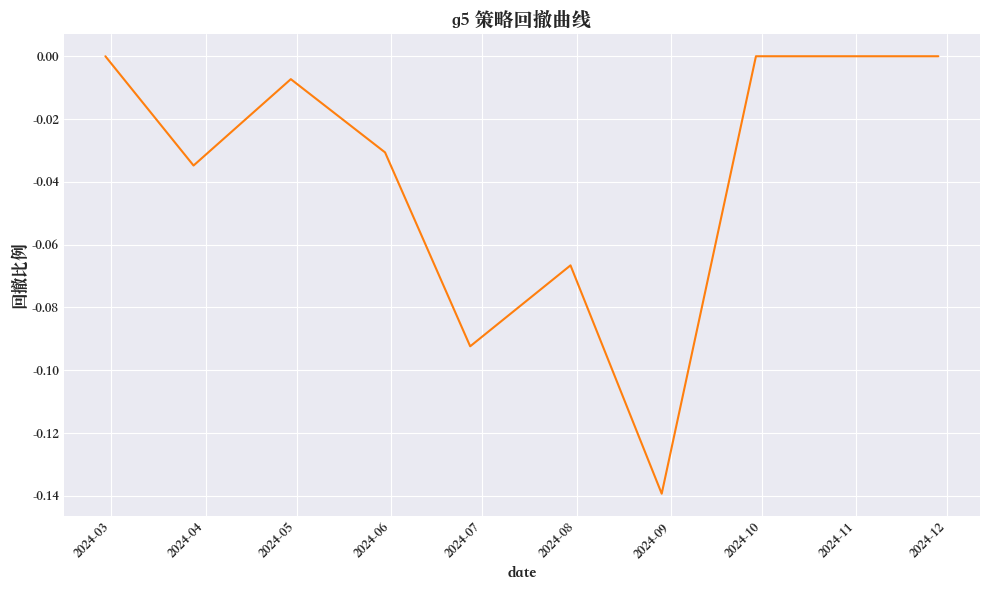

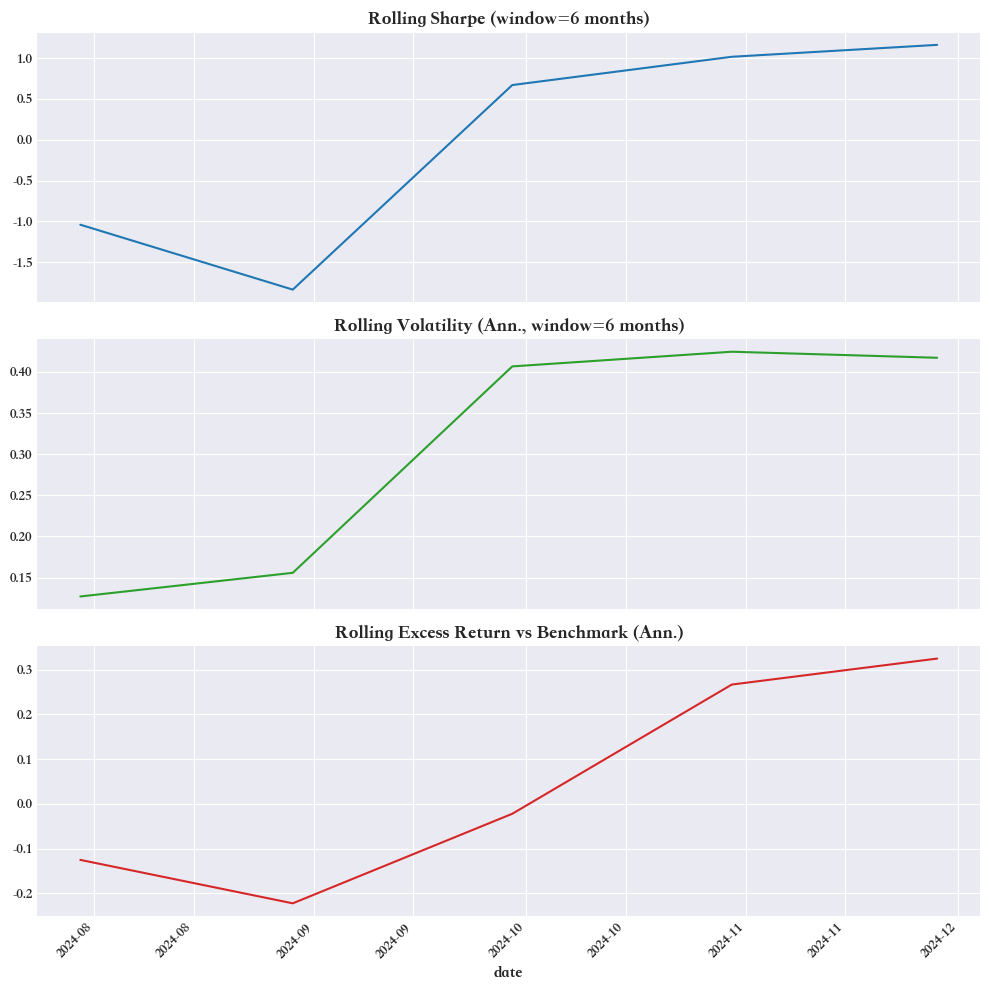

In [25]:
# 回撤曲线与滚动指标（以 g5 为主策略，若存在）
if 'g5' in series_dict:
    strat = series_dict['g5']
    dd = drawdown_series(strat)
    fig, ax = plt.subplots()
    dd.plot(ax=ax, color='C1')
    ax.set_title('g5 策略回撤曲线')
    ax.set_ylabel('回撤比例')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    window = 6
    roll_sharpe = strat.rolling(window).apply(lambda x: sharpe_ratio(x), raw=False)
    roll_vol = strat.rolling(window).std() * np.sqrt(PER_YEAR)
    if 'benchmark' in series_dict:
        roll_excess = (strat - series_dict['benchmark']).rolling(window).mean() * PER_YEAR
    else:
        roll_excess = pd.Series(index=strat.index, dtype=float)

    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
    roll_sharpe.plot(ax=axes[0], color='C0')
    axes[0].set_title('Rolling Sharpe (window=6 months)')
    roll_vol.plot(ax=axes[1], color='C2')
    axes[1].set_title('Rolling Volatility (Ann., window=6 months)')
    roll_excess.plot(ax=axes[2], color='C3')
    axes[2].set_title('Rolling Excess Return vs Benchmark (Ann.)')
    axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('g5 不存在，跳过回撤与滚动指标分析')

In [26]:
# 回归分析：g5 ~ benchmark
if ('g5' in series_dict) and ('benchmark' in series_dict):
    ab = alpha_beta(series_dict['g5'], series_dict['benchmark'])
    print('回归结果（g5 ~ benchmark）：')
    for k in ['alpha', 'beta', 'alpha_t', 'beta_t', 'r2']:
        v = ab.get(k, np.nan)
        if isinstance(v, (int, float)) and (not np.isnan(v)):
            print('  %s: %.4f' % (k, v))
        else:
            print('  %s: %s' % (k, v))
else:
    print('缺少 g5 或 benchmark，无法做回归分析')

回归结果（g5 ~ benchmark）：
  alpha: 0.0986
  beta: 1.1568
  alpha_t: 0.3918
  beta_t: 3.3094
  r2: 0.5779


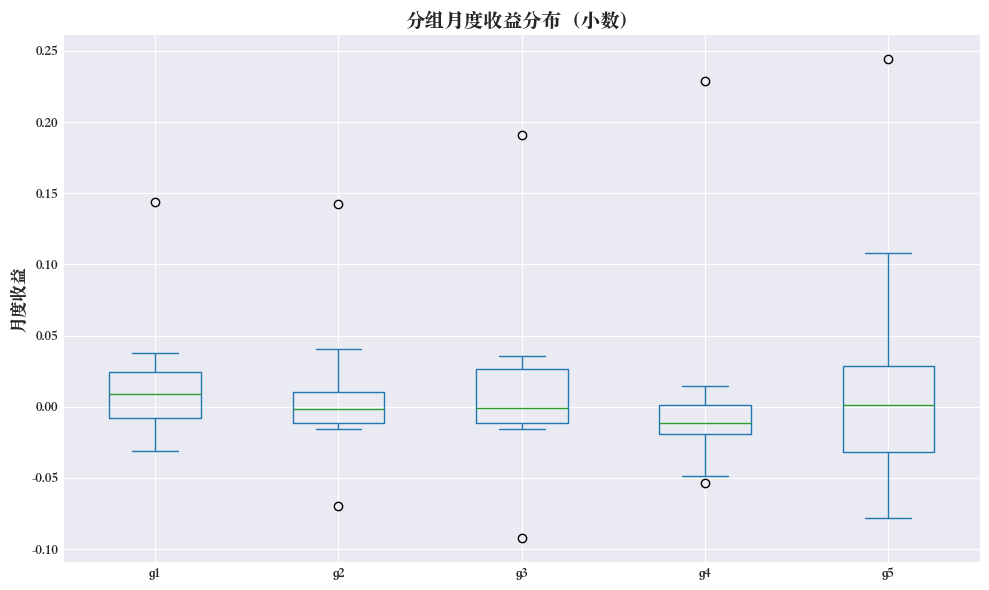

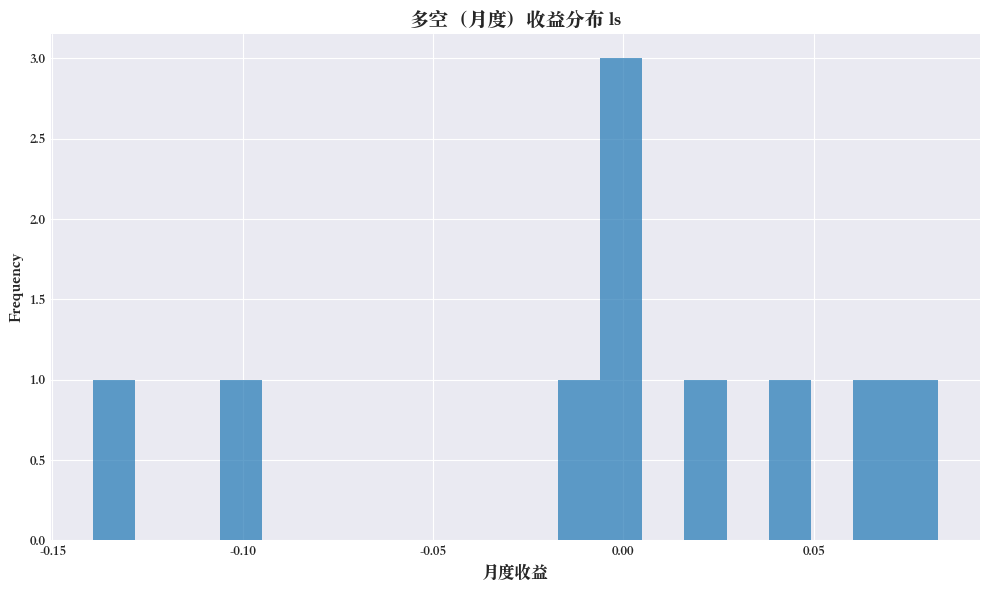

In [27]:
# 分组对比：g1..g5 月度收益分布 & ls 分布
group_cols = [c for c in ['g1', 'g2', 'g3', 'g4', 'g5'] if c in monthly_ret_df.columns]
if group_cols:
    fig, ax = plt.subplots()
    monthly_ret_df[group_cols].plot(kind='box', ax=ax)
    ax.set_title('分组月度收益分布（小数）')
    ax.set_ylabel('月度收益')
    plt.tight_layout()
    plt.show()
else:
    print('未找到 g1..g5 列，跳过分组对比箱线图')

if 'ls' in monthly_ret_df.columns:
    fig, ax = plt.subplots()
    monthly_ret_df['ls'].plot(kind='hist', bins=20, alpha=0.7, ax=ax)
    ax.set_title('多空（月度）收益分布 ls')
    ax.set_xlabel('月度收益')
    plt.tight_layout()
    plt.show()
else:
    print('未找到 ls 列，跳过多空分布图')

In [28]:
# 相关性分析
if ('g5' in series_dict) and ('benchmark' in series_dict):
    corr_g5_bm = series_dict['g5'].corr(series_dict['benchmark'])
    print('Corr(g5, benchmark) = %.4f' % corr_g5_bm)
    excess = series_dict['g5'] - series_dict['benchmark']
    corr_excess_bm = excess.corr(series_dict['benchmark'])
    print('Corr(excess, benchmark) = %.4f' % corr_excess_bm)
else:
    print('缺少 g5 或 benchmark，跳过相关性分析')

Corr(g5, benchmark) = 0.7602
Corr(excess, benchmark) = 0.1566


### F. 与框架自带统计结果交叉验证

In [29]:
# 尝试展示框架输出的各类检验与统计表
check_keys = [
    '收益率检验',
    '因子显著性统计',
    '因子区分度检验',
    '因子延续性检验',
    '因子稳定性检验',
]
for k in check_keys:
    if k in sections:
        print('=== %s ===' % k)
        display(sections[k].head())
    else:
        print('[INFO] section `%s` 不存在，跳过' % k)

print('\n当前我们计算的核心指标汇总：')
display(metrics_df)
print('\n注意：框架内置统计可能基于日度数据或使用不同的年化口径，因此与本 Notebook 基于月度数据的结果可能存在差异。')

=== 收益率检验 ===


,组名,整体@平均收益(%),整体@标准差(%),整体@夏普比率,整体@胜率(%),整体@最大回撤%(日线),近1年@平均收益(%),近1年@标准差(%),近1年@夏普比率,近1年@胜率(%),...,近2年@平均收益(%),近2年@标准差(%),近2年@夏普比率,近2年@胜率(%),近2年@最大回撤%(日线),近3年@平均收益(%),近3年@标准差(%),近3年@夏普比率,近3年@胜率(%),近3年@最大回撤%(日线)
0,第1组,1.93,5.27,0.37,55.56,-10.44,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,第2组,1.01,5.75,0.18,44.44,-10.85,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,第3组,1.59,7.55,0.21,44.44,-11.60,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,第4组,0.91,8.52,0.11,33.33,-17.13,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,第5组,2.36,9.99,0.24,55.56,-21.54,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


=== 因子显著性统计 ===


,组名,整体@超额均值(%),整体@跟踪误差(%),整体@信息比率,整体@超额概率(%),整体@T-Stat,整体@P-Value,近1年@超额均值(%),近1年@跟踪误差(%),近1年@信息比率,...,近2年@信息比率,近2年@超额概率(%),近2年@T-Stat,近2年@P-Value,近3年@超额均值(%),近3年@跟踪误差(%),近3年@信息比率,近3年@超额概率(%),近3年@T-Stat,近3年@P-Value
0,第1组,0.81,2.65,0.31,66.67,0.92,80.71,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,第2组,-0.10,1.94,-0.05,66.67,-0.16,43.94,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,第3组,0.47,2.47,0.19,55.56,0.58,70.98,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,第4组,-0.20,2.66,-0.08,44.44,-0.23,41.28,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,第5组,1.25,6.54,0.19,55.56,0.57,70.84,None,None,None,...,None,None,None,None,None,None,None,None,None,None


=== 因子区分度检验 ===


,项目,整体@平均收益(%),整体@标准差(%),整体@夏普比率,整体@胜率(%),整体@T-Stat,整体@P-Value,近1年@平均收益(%),近1年@标准差(%),近1年@夏普比率,...,近2年@夏普比率,近2年@胜率(%),近2年@T-Stat,近2年@P-Value,近3年@平均收益(%),近3年@标准差(%),近3年@夏普比率,近3年@胜率(%),近3年@T-Stat,近3年@P-Value
0,第一组vs最后一组,-0.44,7.33,-0.06,44.44,-0.18,43.13,None,None,None,...,None,None,None,None,None,None,None,None,None,None


=== 因子延续性检验 ===


,因子截止日,检验开始日,检验截止日,IC,P-value,end_date,start_date,date
0,2024-02-29,2024-03-01,2024-03-29,0.13,0.36,2024-03-29,2024-03-01,2024-03-29
1,2024-03-29,2024-03-30,2024-04-30,0.11,0.46,2024-04-30,2024-03-30,2024-04-30
2,2024-04-30,2024-05-01,2024-05-31,0.25,0.08,2024-05-31,2024-05-01,2024-05-31
3,2024-05-31,2024-06-01,2024-06-28,0.32,0.03,2024-06-28,2024-06-01,2024-06-28
4,2024-06-28,2024-06-29,2024-07-31,-0.01,0.95,2024-07-31,2024-06-29,2024-07-31


=== 因子稳定性检验 ===


,开始日,上期截止日,间隔期数,自相关系数,买入衰减(%),买入反转(%),卖出衰减(%),卖出反转(%),start_date,end_date,date
0,2024-03-29,2024-02-29,1.0,0.61,50.0,0.0,50.0,0.0,2024-03-29,2024-02-29,2024-02-29
1,2024-04-30,2024-03-29,1.0,0.64,50.0,0.0,50.0,0.0,2024-04-30,2024-03-29,2024-03-29
2,2024-05-31,2024-04-30,1.0,0.97,80.0,0.0,90.0,0.0,2024-05-31,2024-04-30,2024-04-30
3,2024-06-28,2024-05-31,1.0,0.95,70.0,0.0,80.0,0.0,2024-06-28,2024-05-31,2024-05-31
4,2024-07-31,2024-06-28,1.0,0.96,90.0,0.0,90.0,0.0,2024-07-31,2024-06-28,2024-06-28



当前我们计算的核心指标汇总：


,CAGR,AnnVol,Sharpe,Sortino,MaxDD,Calmar,WinRate,MinMonth,MaxMonth,Skew,Kurtosis,VaR95,CVaR95,TrackingError,InfoRatio,Alpha,Beta,Alpha_t,Beta_t,R2
series,,,,,,,,,,,,,,,,,,,,
benchmark,0.121533,0.215217,0.623927,2.103121,-0.052243,2.326298,0.4,-0.0444,0.1799,2.216772,3.817539,0.036705,0.0444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
g5,0.231295,0.327490,0.775352,2.161099,-0.139306,1.660342,0.5,-0.0779,0.2444,1.374643,1.177314,0.071510,0.0779,0.215429,0.485184,0.098591,1.156758,0.391802,3.309420,0.577887
excess_g5_vs_bm,0.104523,0.215429,0.555357,1.657073,-0.108820,0.960512,0.5,-0.0610,0.1524,1.204136,0.768173,0.049930,0.0610,0.279655,-0.167200,0.098591,0.156758,0.391802,0.448475,0.024525
ls,-0.071521,0.239321,-0.196556,-0.320909,-0.229529,-0.311602,0.4,-0.1394,0.0826,-0.817320,-0.258694,0.121895,0.1394,0.377224,-0.602071,0.009064,-0.417811,0.034555,-1.146751,0.141174



注意：框架内置统计可能基于日度数据或使用不同的年化口径，因此与本 Notebook 基于月度数据的结果可能存在差异。


### G. 结论与后续扩展方向

In [30]:
from IPython.display import Markdown, display


def generate_conclusion(metrics_df):
    lines = []
    lines.append('## 策略表现小结')
    if 'g5' in metrics_df.index:
        m = metrics_df.loc['g5']
        lines.append('- 主策略 g5 的年化收益约为 %.2f%% ，年化波动约为 %.2f%% ，Sharpe 约为 %.2f。'
                     % (m['CAGR'] * 100.0, m['AnnVol'] * 100.0, m['Sharpe']))
        lines.append('- g5 的最大回撤约为 %.2f%%，Calmar 比率约为 %.2f。'
                     % (m['MaxDD'] * 100.0, m['Calmar']))
        lines.append('- 月度胜率约为 %.2f%% ，最差 / 最好单月收益分别约为 %.2f%% / %.2f%%。'
                     % (m['WinRate'] * 100.0, m['MinMonth'] * 100.0, m['MaxMonth'] * 100.0))
    if ('benchmark' in metrics_df.index) and ('g5' in metrics_df.index):
        mb = metrics_df.loc['benchmark']
        mg = metrics_df.loc['g5']
        lines.append('- 相比基准，g5 在年化收益（%.2f%% 超额）和风险暴露（Beta≈%.2f）上的表现值得进一步对比。'
                     % ((mg['CAGR'] - mb['CAGR']) * 100.0, mg['Beta']))
    if 'ls' in metrics_df.index:
        ml = metrics_df.loc['ls']
        lines.append('- 多空组合 ls 的年化收益约为 %.2f%% ，Sharpe 约为 %.2f，用于刻画因子截面的区分能力。'
                     % (ml['CAGR'] * 100.0, ml['Sharpe']))

    lines.append('- 滚动指标（Sharpe / 波动率 / 超额收益）显示策略在不同阶段的稳定性，可结合回撤曲线定位表现较差的时段。')
    lines.append('- 若换手率信息可用，可进一步结合交易成本假设，评估净收益与资金容量。')
    lines.append('')
    lines.append('## 后续扩展：多策略对比框架')
    lines.append('- 可以在本 Notebook 基础上，将 `DATA_PATH` 参数化，并对 equal_weights、rule_based、dynamic_weights（当前）、dynamic_weights_without_regime 四个策略依次读取对应 JSON。')
    lines.append('- 为四个策略分别构建月度收益序列与指标表，最终拼接为一个多索引 DataFrame（level0=策略名称，level1=指标名）。')
    lines.append('- 可视化上叠加四条累计收益 / 超额曲线，并对比其回撤、Sharpe、Calmar 等关键风险收益指标。')
    lines.append('- 对于 IC / 区分度 / 稳定性等因子层面的统计，也可以在多策略维度进行并列展示，帮助筛选更稳定、可扩展的组合方式。')
    return '\n'.join(lines)


display(Markdown(generate_conclusion(metrics_df)))


## 策略表现小结
- 主策略 g5 的年化收益约为 23.13% ，年化波动约为 32.75% ，Sharpe 约为 0.78。
- g5 的最大回撤约为 -13.93%，Calmar 比率约为 1.66。
- 月度胜率约为 50.00% ，最差 / 最好单月收益分别约为 -7.79% / 24.44%。
- 相比基准，g5 在年化收益（10.98% 超额）和风险暴露（Beta≈1.16）上的表现值得进一步对比。
- 多空组合 ls 的年化收益约为 -7.15% ，Sharpe 约为 -0.20，用于刻画因子截面的区分能力。
- 滚动指标（Sharpe / 波动率 / 超额收益）显示策略在不同阶段的稳定性，可结合回撤曲线定位表现较差的时段。
- 若换手率信息可用，可进一步结合交易成本假设，评估净收益与资金容量。

## 后续扩展：多策略对比框架
- 可以在本 Notebook 基础上，将 `DATA_PATH` 参数化，并对 equal_weights、rule_based、dynamic_weights（当前）、dynamic_weights_without_regime 四个策略依次读取对应 JSON。
- 为四个策略分别构建月度收益序列与指标表，最终拼接为一个多索引 DataFrame（level0=策略名称，level1=指标名）。
- 可视化上叠加四条累计收益 / 超额曲线，并对比其回撤、Sharpe、Calmar 等关键风险收益指标。
- 对于 IC / 区分度 / 稳定性等因子层面的统计，也可以在多策略维度进行并列展示，帮助筛选更稳定、可扩展的组合方式。